# Torch
## Check GPU¶

In [1]:
import torch
import numpy as np
import sys
sys.path.append('..')

from torchlib.utils import list_device,set_device

# S1: check GPU
#list_device()

# S2: default parameters
set_device(1)
np.set_printoptions(precision = 2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=4)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


Using Device 1 : TITAN Xp


# Set Arguments

In [2]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()

'''Training Parameters'''
parser.add_argument('--batch_size', type=int, default=300, help='minibatch size')
parser.add_argument('--num_epochs', type=int, default=200, help='number of epochs')
parser.add_argument('--grad_clip', type=float, default=5., help='clip gradients at this value')
parser.add_argument('--learning_rate', type=float, default=0.05, help='learning rate')
parser.add_argument('--learning_rate_clip', type=float, default=0.0000001, help='learning rate clip')
parser.add_argument('--decay_rate', type=float, default=.7, help='decay rate for rmsprop')
parser.add_argument('--weight_decay', type=float, default=.0001, help='decay rate for rmsprop')
parser.add_argument('--batch_norm_decay', type=float, default=.999, help='decay rate for rmsprop')
parser.add_argument('--keep_prob', type=float, default=1.0, help='dropout keep probability')
parser.add_argument('--lamda_weights', type=float, default=.01, help='lamda weight')
parser.add_argument('--data_argumentation', type=bool, default=True, help='whether do data argument')
parser.add_argument('--is_normalization', type=bool, default=True, help='whether do data nomalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int, help='Input images will be resized to this for data argumentation.')
parser.add_argument('--output_dim', default=3, type=int, help='output dimention.')
parser.add_argument('--feat_dim', default=128, type=int, help='feature dimention.')

'''Configure'''
parser.add_argument('--network', type=str, default='vggnet_localization')
parser.add_argument('--model_dir', type=str, default='/notebooks/global_localization/kmeans_gps', help='rnn, gru, or lstm')

parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/2012_01_08',
                                                            '/notebooks/michigan_nn_data/2012_01_15',
                                                            '/notebooks/michigan_nn_data/2012_01_22',
                                                            '/notebooks/michigan_nn_data/2012_02_02',
                                                            '/notebooks/michigan_nn_data/2012_02_04',
                                                            '/notebooks/michigan_nn_data/2012_02_05',
                                                            '/notebooks/michigan_nn_data/2012_03_31',
                                                            '/notebooks/michigan_nn_data/2012_09_28'])
'''
#parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/test'])
parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/2012_01_08'])
'''
parser.add_argument('--norm_tensor', type=str, default = ['/notebooks/global_localization/norm_mean_std.pt'])

parser.add_argument('--seed', default=1337, type=int)
parser.add_argument('--save_every', type=int, default=500, help='save frequency')
parser.add_argument('--display', type=int, default=10, help='display frequency')
parser.add_argument('--tensorboard', type=bool, default=True, help='open tensorboard')
parser.add_argument('--num_gp', type=int, default=15, help='number of local gps')

sys.argv = ['']
args = parser.parse_args()

# Load Dataset

In [3]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tf.transformations as tf_tran
from tqdm import tqdm
from PIL import Image
import numpy as np
import random

#import gpflow.multioutput.kernels as mk
import gpytorch

import torch.nn as nn
import torch.optim as optim
from torchlib import resnet, vggnet
from torchlib.cnn_auxiliary import normalize, denormalize_navie, denormalize, get_relative_pose, translational_rotational_loss
from torchlib.utils import LocalizationDataset, display_loss, data2tensorboard
import time

transform = transforms.Compose([transforms.ToTensor()])
dataset = LocalizationDataset(dataset_dirs = args.train_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, get_pair = False)

if len(args.train_dataset)>7:
    [args.norm_mean, args.norm_std] = [torch.tensor(x) for x in dataset.get_norm()]
    torch.save([args.norm_mean, args.norm_std], *args.norm_tensor)
    print('Save norm and std:',*args.norm_tensor)
else:
    [args.norm_mean, args.norm_std] = torch.load(*args.norm_tensor)
    print('Load norm and std:',*args.norm_tensor)


dataloader = DataLoader(dataset, batch_size=args.batch_size, \
                        shuffle=True, num_workers=0, \
                        drop_last=True, pin_memory=True)

100%|██████████| 14037/14037 [00:27<00:00, 512.94it/s]


Save norm and std: /notebooks/global_localization/norm_mean_std.pt


# K-means

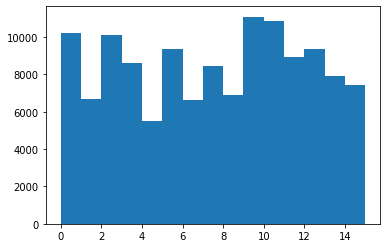

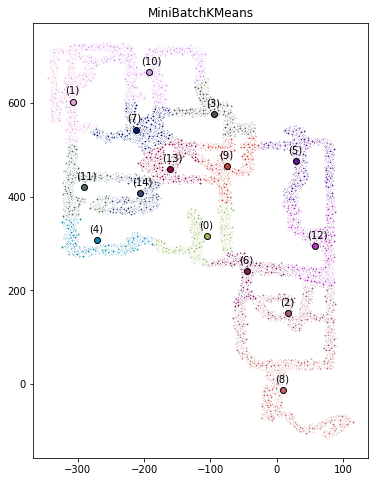

Save centers to /notebooks/global_localization/kmeans_gps/k-means_gp15.npy


In [48]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances_argmin

def draw(X,centers,seed):
    num_gp = centers.shape[0]
    np.random.seed(seed)
    r = lambda: np.random.randint(0,255)
    colors = ['#%02X%02X%02X' % (r(),r(),r()) for _ in range(num_gp)]
    
    labels = pairwise_distances_argmin(X, centers)
    
    fig = plt.figure(figsize=(6, 8))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(num_gp):
        points_mask = labels == i
        center = centers[i]
        ax.plot(X[points_mask, 0], X[points_mask, 1], 'w',
                markerfacecolor=colors[i], marker='.')
        ax.plot(center[0], center[1], 'o', 
                markerfacecolor=colors[i], markeredgecolor='k', markersize=6)
        ax.annotate("(%s)" % i, xy=center, xytext=(-8, 8), textcoords='offset points')
    ax.set_title('MiniBatchKMeans')
    plt.show()

def save_centers(centers):
    filename = 'k-means_gp{}.npy'.format(str(centers.shape[0]))
    file_path = os.path.join(args.model_dir,filename)
    np.save(file_path,centers)
    print('Save centers to', file_path)

X = np.array(dataset.Targets)[:,:2]
np.random.seed(args.seed)
mbk = MiniBatchKMeans(n_clusters = args.num_gp)
mbk.fit(X)
dis = Counter(mbk.labels_)
plt.hist(mbk.labels_, bins = range(args.num_gp+1)) 

centers = mbk.cluster_centers_
draw(X,centers, args.seed)
save_centers(centers)

In [ ]:
[[4,6,9], #0
 [7,10,11], #1
 [6,8,12], #2
 [7,9,10], #3
 [0,11], #4
 [9,12], #5
 [0,2,12], #6
 [1,3,10,13], #7
 [2], #8
 [0,3,5,13], #9
 [1,3,7], #10
 [1,4,14], #11
 [2,5,6], #12
 [7,9,14], #13
 [11,13] #14
]

# Define Model

In [103]:
from torchlib.model import Backbone, NN, GP#, GPNode_local
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.likelihoods import BernoulliLikelihood

class BasicTrainer:
    def __init__(self,norm_mean,norm_std):
        self.model = None
        self.norm_mean = args.norm_mean.cuda()
        self.norm_std = args.norm_std.cuda()
        
    def disable_requires_grad(self,model):
        for param in model.parameters():
            param.requires_grad = False
            
    def load_model(self, file_name = 'pretrained.pth', strict = True):
        # load file info
        state_dict = torch.load(os.path.join(args.model_dir, file_name))
        if 'net.resnet.conv1.weight' in state_dict:
            print('Transform from old model.')
            # Part 1: backbone
            backbone_state_dict = self._from_old_model(state_dict,'backbone')
            print('Backbone parameters layer:',len(backbone_state_dict.keys()))
            self.model.backbone.load_state_dict(backbone_state_dict,strict = True)
            # Part 2: nn
            nn_state_dict = self._from_old_model(torch.load(os.path.join(args.model_dir, file_name)),'nn')
            print('NN parameters layer:',len(nn_state_dict.keys()))
            self.model.nn.load_state_dict(nn_state_dict,strict = strict)
        else:
            print('Parameters layer:',len(state_dict.keys()))
            # load file to model
            self.model.load_state_dict(state_dict,strict = strict)
        # Display model structure
        #print('Model Structure:')
        #for name, param in self.model.named_parameters():
        #    print(name, param.shape)
        print('Successfully loaded model...')
        print('Parameters layer:',len(self.model.state_dict().keys()))
    
    def _from_old_model(self, state_dict, select = 'backbone'):
        if select == 'backbone':
            for key in list(state_dict):
                if 'net.resnet.' in key:
                    state_dict[key.replace('net.resnet.','resnet.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        elif select == 'nn':
            for key in list(state_dict):
                if 'net.global_regressor.' in key:
                    state_dict[key.replace('net.global_regressor.','global_regressor.')] = state_dict.pop(key)
                elif 'net.global_context.' in key:
                    state_dict[key.replace('net.global_context.','global_context.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        return state_dict
    
    def save_model(self, file_name = 'model-{}-{}.pth'):
        checkpoint_path = os.path.join(args.model_dir, file_name)
        torch.save(self.model.state_dict(),checkpoint_path)
        print('Saving model to ' +  file_name)
        
    def show_require_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print (name, param.shape)

class GPNode_local(nn.Module):
    def __init__(self,inducing_points):
        super(GPNode_local,self).__init__()
        output_dim = inducing_points.shape[0] # 3-dim
        feat_dim = inducing_points.shape[-1]
        
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim) 
        
    def forward(self,input_data):
        output = self.gp(input_data)
        return output

class GPNode_global(nn.Module):
    def __init__(self,inducing_points,num_gp,p):
        super(GPNode_global,self).__init__()
        
        self.layer = nn.Sequential(
                    nn.Linear(128,128),
                    nn.ReLU(True),
                    nn.Dropout(p = p),
                    nn.Linear(128,128),
        )
        self.gp = GP(inducing_points,num_gp)
        self.likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=num_gp, num_classes=num_gp)

    def forward(self,input_data):
        input_data = self.layer(input_data)
        output = self.gp(input_data)
        return output

class Model(nn.Module):
    def __init__(self,num_gp,p=0.4):
        super().__init__()
        self.num_gp = num_gp

        # Part 1: basic NN
        self.backbone = Backbone()
        self.nn = NN()
        # Part 2: global GP
        inducing_points = torch.zeros(self.num_gp, 300, args.feat_dim) # num_grid x 300 x 128
        self.global_gp = GPNode_global(inducing_points,self.num_gp,p)
        
        # Part 3: local GPs
        self.local_gps = nn.ModuleList()
        for i in range(self.num_gp):
            inducing_points = torch.zeros(args.output_dim, 300, args.feat_dim)
            gp = GPNode_local(inducing_points)
            self.local_gps.append(gp)
        
    def forward_nn(self, input_data):
        dense_feat = self.backbone(input_data)
        output, feature_t, feature_r = self.nn(dense_feat)
        rot_pred = torch.split(output, [3, 4], dim=1)[1] # 4-dimention  
        return feature_t, rot_pred
    '''
    def forward_gp(self, gp, trans_feat):
        trans_pred = gp(trans_feat)
        return trans_pred
    '''

In [172]:
class Trainer(BasicTrainer):
    def __init__(self, centers,norm_mean, norm_std,
                 regressor_context_rate = [0.0,0.0],
                 is_training=True, disable_rot_learning = True, 
                 train_global_gp = True, train_local_gps = True):
        
        super().__init__(norm_mean, norm_std)
        self.centers = centers
        self.model = Model(centers.shape[0]).cuda()
        self.disable_rot_learning = disable_rot_learning
        self.train_global_gp = train_global_gp
        self.train_local_gps = train_local_gps
        
        self.disable_requires_grad(self.model.backbone)
        
        if is_training:
            # training tool
            self.optimizer = optim.Adam(self._optimize(regressor_context_rate))
            self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                                             lr_lambda=lambda epoch: args.decay_rate**epoch)
            #self.scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=self.optimizer, T_max = 80)
        else:
            self.disable_requires_grad(self.model)
            
    def _optimize(self,regressor_context_rate):
        optimizer = list()
        # Local GPs
        if self.train_local_gps:
            optimizer += [
                    {'params': self.model.local_gps.parameters(), \
                     'lr': args.learning_rate,'weight_decay':args.weight_decay}]            
        else:
            self.disable_requires_grad(self.model.local_gps)
            
        # Global GP
        if self.train_global_gp:
            optimizer += [{'params': self.model.global_gp.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        else:
            self.disable_requires_grad(self.model.global_gp)
            
        # NN
        if regressor_context_rate[0]!=0:
            optimizer += [{'params': self.model.nn.global_regressor.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[0],'weight_decay':args.weight_decay}]
            print('Regressor learn rate:',regressor_context_rate[0])
        else:
            self.disable_requires_grad(self.model.nn.global_regressor)
                
        if regressor_context_rate[1]!=0:
            optimizer += [{'params': self.model.nn.global_context.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[1],'weight_decay':args.weight_decay}]
            print('Context learn rate:',regressor_context_rate[1])
        else:
            self.disable_requires_grad(self.model.nn.global_context)
            
        if self.disable_rot_learning and regressor_context_rate[1]!=0.0:
            print("Warning: Set 'disable_rot_learning' to False")
            self.disable_rot_learning = False
        
        if self.disable_rot_learning and regressor_context_rate[1]==0.0:
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc1_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc2_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc3_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.logits_r)
                
        return optimizer
    
    def train(self,x,y):
        # Step 0: zero grad
        self.optimizer.zero_grad()
        start = time.time()
        
        label = pairwise_distances_argmin(y[:,:2],self.centers)
        label = torch.from_numpy(label).cuda()
            
        x,y = x.cuda(),y.cuda()
        
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std) # input should be 7 dim
            
        # Step 2: training
        assert self.model.training == True
        
        trans_loss = torch.tensor(0.).cuda()
        global_gp_loss = torch.tensor(0.).cuda()
        local_gps_loss = np.zeros(self.model.num_gp)
        
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        # Step 2-0: rotation
        if not self.disable_rot_learning:
            rot_loss = self._nn_loss(rot_pred,rot_target)
        
        # Step 2-1: global GP classification
        if self.train_global_gp:
            gp = self.model.global_gp # gp + likelihood
            num_data = min(len(dataloader)*args.batch_size,len(dataset)) # !!! not safe
            global_gp_loss = self._gp_loss(gp,num_data,trans_feat,label)
        
        # Step 2-2: local GPs regression
        if self.train_local_gps:
            num_batch_data = 0
            for i,gp in enumerate(self.model.local_gps):
                num_data = dis[i]
                label_mask = label == i
                sub_x = trans_feat[label_mask]
                sub_y = trans_target[label_mask]
                gp_loss = self._gp_loss(gp,num_data,sub_x,sub_y)
                local_gps_loss[i] = float(gp_loss)
                trans_loss += gp_loss * int(sub_y.shape[0])
                num_batch_data += int(sub_y.shape[0])
            trans_loss = trans_loss/num_batch_data
        
        # Step 2-3: rotation 
        if not self.disable_rot_learning:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss + args.lamda_weights * rot_loss
            else:
                total_loss = trans_loss + args.lamda_weights * rot_loss
        else:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss
            else:
                total_loss = trans_loss
            
        #Step 3: update
        if self.train_global_gp or self.train_local_gps:
            total_loss.backward()
            self.optimizer.step()
        
        batch_time = time.time() - start
        return float(total_loss), float(global_gp_loss), local_gps_loss, batch_time
        
    def _nn_loss(self,rot_pred,rot_target):
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        return rot_loss
        
    def _gp_loss(self,gp,num_data,trans_feat,trans_target):
        trans_pred = gp(trans_feat)
        #mll = gpytorch.mlls.VariationalELBO(gp.likelihood, gp.gp, 
        #                                    num_data=num_data).cuda()
        mll = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood, gp.gp, 
                                            num_data=num_data).cuda()
        
        trans_loss = -1.*mll(trans_pred, trans_target)
        return trans_loss
    
    def _eval_gp(self, gp, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = gp.likelihood(trans_pred).mean, gp.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples
    
    def eval_classifier(self,x,y):
        label = pairwise_distances_argmin(y[:,:2],self.centers) # n x ,
        label = torch.from_numpy(label).cuda() # n x ,
        x = x.cuda()
        
        assert self.model.training == False
    
        trans_feat, rot_pred = self.model.forward_nn(x)
        with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
            gp = self.model.global_gp # gp + likelihood
            output = gp(trans_feat)
            output = gp.likelihood(output)
            pred = output.probs.mean(0).argmax(-1)
        return pred, label
    
    def eval_forward(self,x,y,num_sample = 100, output_denormalize = True, label_from_gp = True):
        # Step 1: get data
        if not label_from_gp:
            label = pairwise_distances_argmin(y[:,:2],self.centers) # n x ,
        else:
            label,_ = self.eval_classifier(x.cpu(),y.cpu())
            
        x,y = x.cuda(),y.cuda()
        
        # Step 2: forward
        assert self.model.training == False
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        trans_pred = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_mean = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_var = torch.zeros(y.shape[0],args.output_dim).cuda()
        
        for i,gp in enumerate(self.model.local_gps):
            label_mask = label == i
            sub_x = trans_feat[label_mask]
            sub_trans_pred = gp(sub_x)
            sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
            if args.is_normalization and output_denormalize:
                trans_pred[label_mask] = denormalize_navie(sub_trans_pred,self.norm_mean,self.norm_std)
                trans_mean[label_mask] = denormalize_navie(sub_trans_mean,self.norm_mean,self.norm_std)
                trans_var[label_mask] = sub_trans_var.mul(self.norm_std)
            else:
                trans_pred[label_mask] = sub_trans_pred
                trans_mean[label_mask] = sub_trans_mean
                trans_var[label_mask] = sub_trans_var
                    
        samples = self._sample(trans_mean, trans_var, num_sample)
        
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples
    
args.learning_rate = 0.0004
args.decay_rate = 0.75
args.save_every = 1000
    
trainer = Trainer(centers,args.norm_mean,args.norm_std,
                  regressor_context_rate = [0.2,0.0],
                  train_global_gp=True, train_local_gps=True, disable_rot_learning=True)

trainer.load_model('pretrained_global_local.pth')
trainer.show_require_grad()

Regressor learn rate: 0.2
Parameters layer: 509
Successfully loaded model...
Parameters layer: 509
nn.global_regressor.regressor.fc1_trans.0.weight torch.Size([4096, 6400])
nn.global_regressor.regressor.fc1_trans.0.bias torch.Size([4096])
nn.global_regressor.regressor.fc2_trans.0.weight torch.Size([4096, 4096])
nn.global_regressor.regressor.fc2_trans.0.bias torch.Size([4096])
nn.global_regressor.regressor.fc3_trans.0.weight torch.Size([128, 4096])
nn.global_regressor.regressor.fc3_trans.0.bias torch.Size([128])
nn.global_regressor.regressor.logits_t.weight torch.Size([3, 128])
nn.global_regressor.regressor.logits_t.bias torch.Size([3])
global_gp.layer.0.weight torch.Size([128, 128])
global_gp.layer.0.bias torch.Size([128])
global_gp.layer.3.weight torch.Size([128, 128])
global_gp.layer.3.bias torch.Size([128])
global_gp.gp.variational_strategy.base_variational_strategy.inducing_points torch.Size([15, 300, 128])
global_gp.gp.variational_strategy.base_variational_strategy._variational_di

# Training

In [173]:
if args.tensorboard:
    import os
    os.system('rm -rf runs/kmeans_gps')
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter('runs/kmeans_gps')

## Training Epoch

In [174]:
trainer.model.train()
for e in range(args.num_epochs):
#for e in range(4):
    train_loss = 0.
    for b, data in enumerate(dataloader, 0):
        x,y = data.values()
        
        single_loss, global_gp_loss, local_gps_loss, batch_time = trainer.train(x,y)
        
        with torch.no_grad():
            train_loss += single_loss
            if args.tensorboard:
                data2tensorboard(writer,single_loss,train_loss/(b+1),e*len(dataloader)+(b+1))
                if trainer.train_global_gp:
                    writer.add_scalars('global_gp_loss',
                       {'gp':global_gp_loss},e*len(dataloader)+(b+1))
                if trainer.train_local_gps:
                    writer.add_scalars('local_gps_loss',
                       {'gp'+str(i):local_gps_loss[i] for i in range(trainer.model.num_gp) if local_gps_loss[i] != 0},
                       e*len(dataloader)+(b+1))
            if ((b+1)%args.display == 0):
                display_loss(e*len(dataloader)+(b+1),args.num_epochs*len(dataloader),e,
                              train_loss/(b+1),batch_time,trainer.scheduler.get_last_lr()[0])          
            if (e * len(dataloader) + (b+1)) % args.save_every == 0:
                trainer.save_model('model-{}-{}.pth'.format(e, e * len(dataloader) + (b+1)))
            if trainer.scheduler.get_last_lr()[0] > args.learning_rate_clip and (e * len(dataloader) + (b+1)) % 150 == 0:
                trainer.scheduler.step()

10/85400 (epoch 0), train_loss = -8.36677608, time/batch = 1.268, learning rate = 0.00040000
20/85400 (epoch 0), train_loss = -8.40174785, time/batch = 1.275, learning rate = 0.00040000
30/85400 (epoch 0), train_loss = -8.41544545, time/batch = 1.269, learning rate = 0.00040000
40/85400 (epoch 0), train_loss = -8.41170268, time/batch = 1.274, learning rate = 0.00040000
50/85400 (epoch 0), train_loss = -8.41483217, time/batch = 1.263, learning rate = 0.00040000
60/85400 (epoch 0), train_loss = -8.41691869, time/batch = 1.267, learning rate = 0.00040000
70/85400 (epoch 0), train_loss = -8.42193044, time/batch = 1.263, learning rate = 0.00040000
80/85400 (epoch 0), train_loss = -8.42835338, time/batch = 1.276, learning rate = 0.00040000
90/85400 (epoch 0), train_loss = -8.43037141, time/batch = 1.270, learning rate = 0.00040000
100/85400 (epoch 0), train_loss = -8.43437513, time/batch = 1.288, learning rate = 0.00040000
110/85400 (epoch 0), train_loss = -8.43691615, time/batch = 1.271, le

904/85400 (epoch 2), train_loss = -8.63145395, time/batch = 1.276, learning rate = 0.00007119
914/85400 (epoch 2), train_loss = -8.63125273, time/batch = 1.265, learning rate = 0.00007119
924/85400 (epoch 2), train_loss = -8.63306953, time/batch = 1.283, learning rate = 0.00007119
934/85400 (epoch 2), train_loss = -8.63578387, time/batch = 1.271, learning rate = 0.00007119
944/85400 (epoch 2), train_loss = -8.63548255, time/batch = 1.266, learning rate = 0.00007119
954/85400 (epoch 2), train_loss = -8.63559571, time/batch = 1.273, learning rate = 0.00007119
964/85400 (epoch 2), train_loss = -8.63460684, time/batch = 1.273, learning rate = 0.00007119
974/85400 (epoch 2), train_loss = -8.63398025, time/batch = 1.288, learning rate = 0.00007119
984/85400 (epoch 2), train_loss = -8.63449229, time/batch = 1.282, learning rate = 0.00007119
994/85400 (epoch 2), train_loss = -8.63305817, time/batch = 1.279, learning rate = 0.00007119
Saving model to model-2-1000.pth
1004/85400 (epoch 2), train

KeyboardInterrupt: 

# Evaluation

In [175]:
from torch.distributions import Normal
trainer.model.eval()

for b, data in enumerate(dataloader, 0):
    x,y = data.values()
    trans_pred, rot_pred, trans_target, rot_target, samples = trainer.eval_forward(x,y,label_from_gp=False)
    break

In [176]:
trans_pred

tensor([[   -34.2522,    509.0919,     -2.7957],
        [  -133.7673,    288.1412,    -10.5845],
        [    28.6536,    421.2094,     -2.0012],
        [   -58.5152,    174.4498,     -3.4142],
        [   -85.4352,    465.1348,    -10.6594],
        [    31.1824,    430.9709,     -2.0291],
        [  -282.8110,    283.8710,    -11.3455],
        [   -14.5881,    -23.5896,      0.6039],
        [  -213.4894,    315.9652,    -11.3402],
        [    36.2667,    465.9057,     -2.4521],
        [  -308.3348,    538.4124,    -12.6641],
        [  -130.6297,    282.8967,    -10.7358],
        [    75.2643,    250.1551,     -2.1850],
        [  -274.2068,    287.7802,    -11.2796],
        [  -202.6925,    522.5247,    -12.5369],
        [  -204.0695,    545.6012,    -12.1168],
        [  -312.6787,    359.7265,    -11.3651],
        [  -180.9775,    665.0211,    -12.7718],
        [  -231.4374,    533.9678,    -12.2543],
        [  -283.2661,    666.7821,    -14.3171],
        [  -247.1208

In [177]:
trans_target

tensor([[   -34.3031,    509.0026,     -1.9084],
        [  -134.2226,    288.0437,    -10.6021],
        [    28.8002,    420.9614,     -1.9753],
        [   -58.1535,    174.5087,     -3.4149],
        [   -85.5763,    465.3431,    -10.6558],
        [    32.0318,    429.7228,     -2.0060],
        [  -283.0036,    283.8252,    -11.3837],
        [   -13.9980,    -27.7101,      0.6702],
        [  -211.7712,    315.4096,    -11.3103],
        [    35.3343,    466.3541,     -2.4415],
        [  -308.8127,    536.9760,    -12.6172],
        [  -130.3086,    282.4850,    -10.7323],
        [    75.7685,    249.9033,     -2.1767],
        [  -275.4838,    288.0846,    -11.2583],
        [  -202.2198,    522.6343,    -12.5268],
        [  -203.9398,    544.2481,    -12.1541],
        [  -312.3338,    358.0542,    -11.3585],
        [  -182.1164,    664.2419,    -12.8334],
        [  -229.7831,    534.0959,    -12.2484],
        [  -282.0883,    666.5634,    -14.2307],
        [  -247.0255

In [178]:
from torch.distributions import Normal
trainer.model.eval()

error_num = 0
total_num = 0
for b, data in enumerate(dataloader, 0):
    x,y = data.values()
    pred, target = trainer.eval_classifier(x,y)
    acc = float(torch.sum(pred - target == 0))/float(target.shape[0])
    error_num += float(torch.sum(pred - target != 0))
    total_num += float(target.shape[0])
    if error_num >0:
        #break
        pass
    
    if b % 10 == 0:
        print("%.2f" % acc,'-',float(torch.sum(pred - target != 0)),'/',float(target.shape[0]))
        
print("ACC: %.2f" % (1-(error_num/total_num)))
print('Total error number:', error_num)

0.99 - 4.0 / 300.0
0.99 - 2.0 / 300.0
0.98 - 5.0 / 300.0
1.00 - 1.0 / 300.0
0.98 - 5.0 / 300.0
0.99 - 2.0 / 300.0
1.00 - 1.0 / 300.0
0.99 - 4.0 / 300.0
0.99 - 2.0 / 300.0
1.00 - 1.0 / 300.0
0.98 - 5.0 / 300.0
0.97 - 8.0 / 300.0
0.99 - 3.0 / 300.0
0.99 - 3.0 / 300.0
1.00 - 1.0 / 300.0
1.00 - 1.0 / 300.0
1.00 - 1.0 / 300.0
0.99 - 2.0 / 300.0
0.99 - 4.0 / 300.0
0.99 - 2.0 / 300.0
0.99 - 4.0 / 300.0
0.99 - 2.0 / 300.0
0.99 - 2.0 / 300.0
0.99 - 3.0 / 300.0
1.00 - 1.0 / 300.0
0.99 - 3.0 / 300.0
1.00 - 1.0 / 300.0
0.99 - 4.0 / 300.0
1.00 - 1.0 / 300.0
1.00 - 1.0 / 300.0
0.98 - 5.0 / 300.0
0.99 - 3.0 / 300.0
0.99 - 3.0 / 300.0
1.00 - 1.0 / 300.0
0.99 - 3.0 / 300.0
0.99 - 3.0 / 300.0
1.00 - 1.0 / 300.0
0.99 - 2.0 / 300.0
0.99 - 2.0 / 300.0
1.00 - 1.0 / 300.0
0.99 - 3.0 / 300.0
1.00 - 0.0 / 300.0
0.99 - 2.0 / 300.0
ACC: 0.99
Total error number: 1136.0


In [179]:
x = x.cuda()

trans_feat, rot_pred = trainer.model.forward_nn(x)
with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
    gp = trainer.model.global_gp # gp + likelihood
    output = gp(trans_feat)
    output = gp.likelihood(output)
    pred_i = output.probs.mean(0)#.argmax(-1)
    pred_1 = pred_i.argsort(-1)[:,-3:][:,[2,1,0]][:,0]
    pred_2 = pred_i.argsort(-1)[:,-3:][:,[2,1,0]][:,1]

In [180]:
pred_2[pred - target != 0]

tensor([ 1,  7, 10], device='cuda:1')

In [181]:
target[pred - target != 0]

tensor([ 1,  7, 10], device='cuda:1')

In [182]:
pred_1[pred - target != 0]

tensor([7, 3, 7], device='cuda:1')

In [183]:
pred[pred - target != 0]

tensor([7, 3, 7], device='cuda:1')

In [184]:
pred_1[:2]

tensor([3, 7], device='cuda:1')

In [185]:
pred_2[:2]

tensor([9, 1], device='cuda:1')

In [187]:
pred_i[:2]

tensor([[    0.0000,     0.0000,     0.0000,     0.9980,     0.0000,     0.0007,
             0.0000,     0.0000,     0.0000,     0.0012,     0.0002,     0.0000,
             0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0005,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.9986,     0.0000,     0.0000,     0.0004,     0.0000,
             0.0000,     0.0004,     0.0000]], device='cuda:1')